In [8]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [9]:
!pip install ray #[tune]==2.7.0

In [10]:
import numpy as np
import os
import tempfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from filelock import FileLock
from torch.utils.data import random_split, DataLoader
import torchvision
import torchvision.transforms as transforms
from typing import Dict
import ray
from ray import train, tune, get, put
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler

In [11]:
class CNN(nn.Module):
    def __init__(self, num_filters=32, dropout_rate=0.5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.conv2 = nn.Conv2d(num_filters, num_filters * 2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters * 2)
        self.fc1 = nn.Linear(num_filters * 2 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

trainset_ref = put(trainset)
testset_ref = put(testset)

In [13]:
def train_cifar(config, checkpoint_dir=None):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    trainset = get(trainset_ref)
    testset = get(testset_ref)

    trainloader = DataLoader(trainset, batch_size=config["batch_size"], shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=config["batch_size"], shuffle=False, num_workers=2)

    model = CNN(num_filters=config["num_filters"], dropout_rate=config["dropout"]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    for epoch in range(10):
        print(f"Epoch {epoch + 1}")
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        tune.report(metrics = {"loss": running_loss / len(trainloader), "accuracy": accuracy*100})

In [17]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=0):
    config = {
        "num_filters": tune.choice([16, 32, 64, 128]),
        "lr": tune.choice([1e-2, 1e-3]),
        "batch_size": tune.choice([16, 32, 64]),
        "dropout": tune.choice([0.3, 0.4, 0.5])
    }
    scheduler = ASHAScheduler(max_t=max_num_epochs, grace_period=1, reduction_factor=2)
    tuner = tune.Tuner(
        tune.with_resources(tune.with_parameters(train_cifar), resources={"cpu": 2, "gpu": gpus_per_trial}),
        tune_config=tune.TuneConfig(metric="loss", mode="min", scheduler=scheduler, num_samples=num_samples),
        param_space=config,
    )
    results = tuner.fit()
    best_result = results.get_best_result("loss", "min")
    print("Best Config:", best_result.config)
    print("Best Validation Accuracy:", best_result.metrics["accuracy"])

    return results

In [18]:
results = main(num_samples=20, max_num_epochs=10, gpus_per_trial=1)

2025-03-17 18:49:16,292	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


+--------------------------------------------------------------------+
| Configuration for experiment     train_cifar_2025-03-17_18-49-16   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 20                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_cifar_2025-03-17_18-49-16

Trial status: 20 PENDING
Current time: 2025-03-17 18:49:16. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------+
| Trial name                status       num_filters      lr     batch_size     dropout |
+--------------------------------------------------------------------------------------

2025-03-17 19:27:08,836	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_cifar_2025-03-17_18-49-16' in 0.0223s.



Trial train_cifar_86ddf_00019 completed after 1 iterations at 2025-03-17 19:27:08. Total running time: 37min 52s
+--------------------------------------------------+
| Trial train_cifar_86ddf_00019 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         21.4927 |
| time_total_s                             21.4927 |
| training_iteration                             1 |
| accuracy                                   26.52 |
| loss                                     2.37832 |
+--------------------------------------------------+

Trial status: 20 TERMINATED
Current time: 2025-03-17 19:27:08. Total running time: 37min 52s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 86ddf_00018 with loss=0.5809078816791324 and params={'num_filters': 16, 'lr': 0.001, 'batch_size': 64, 'dropout': 0.3}
+---------------------------------------------

In [19]:
df = results.get_dataframe()

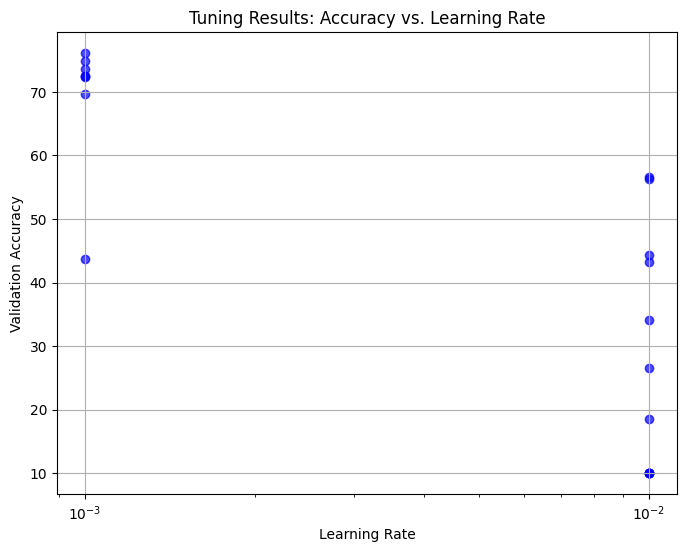

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df["config/lr"], df["accuracy"], c="blue", alpha=0.7)
plt.xscale("log")  # Log scale for better visualization
plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.title("Tuning Results: Accuracy vs. Learning Rate")
plt.grid(True)
plt.show()

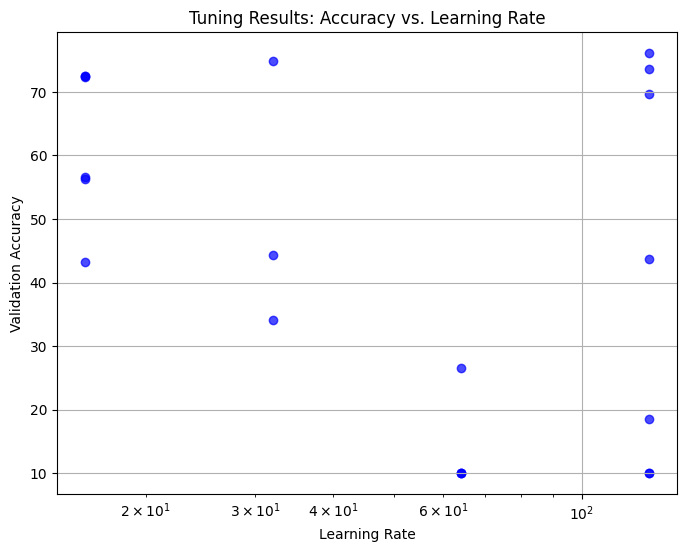

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(df["config/num_filters"], df["accuracy"], c="blue", alpha=0.7)
plt.xscale("log")  # Log scale for better visualization
plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.title("Tuning Results: Accuracy vs. Learning Rate")
plt.grid(True)
plt.show()

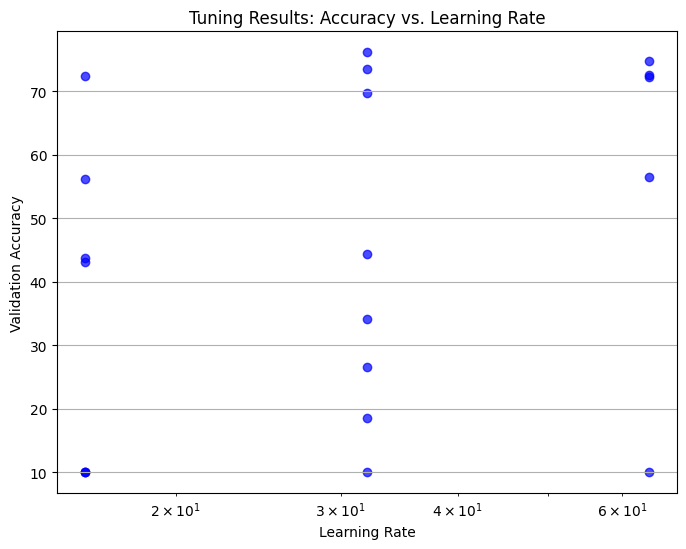

In [27]:
plt.figure(figsize=(8, 6))
plt.scatter(df["config/batch_size"], df["accuracy"], c="blue", alpha=0.7)
plt.xscale("log")  # Log scale for better visualization
plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.title("Tuning Results: Accuracy vs. Learning Rate")
plt.grid(True)
plt.show()

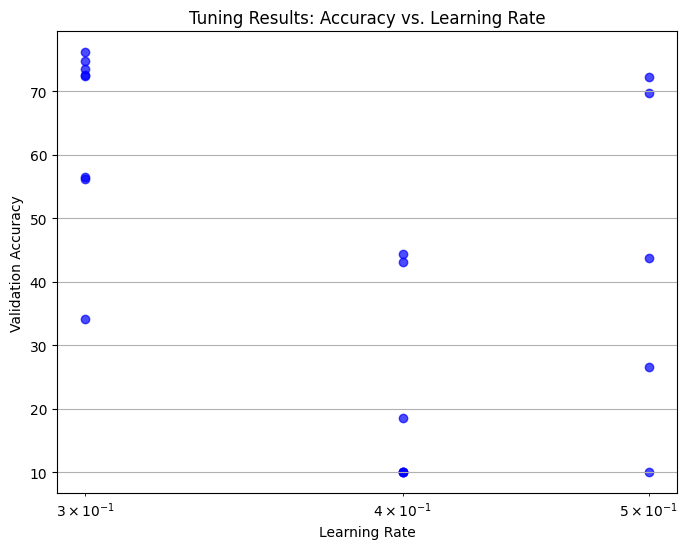

In [28]:
plt.figure(figsize=(8, 6))
plt.scatter(df["config/dropout"], df["accuracy"], c="blue", alpha=0.7)
plt.xscale("log")  # Log scale for better visualization
plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.title("Tuning Results: Accuracy vs. Learning Rate")
plt.grid(True)
plt.show()